# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

## Importacion datos

In [3]:
from modules.get_data import get_data

In [4]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

# Añadir la columna 'event' a df_ws usando el método 'map'
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()
df_ws['event'] = df_ws['week'].map(event_dict)

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event,year,week
0,2011-02-06,SuperBowl,2011,5
1,2011-08-01,Ramadan starts,2011,31
2,2011-11-24,Thanksgiving,2011,47
3,2012-01-01,NewYear,2012,52
4,2012-02-05,SuperBowl,2012,5


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn,event
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32,None
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18,None
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95,None
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54,None
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32,None


___
___

# CREACION FEATS. GENERALES

In [5]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 14.2 MB/s eta 0:00:00


In [6]:
from modules import feature_creation_module as fcm

In [7]:
df_ws = df_ws.drop(columns=['event']) # no nos sirve ahora

In [8]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
        'is_weekend'  # Indica si la semana incluye fines de semana
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [9]:
feature_matrix.head()

,COUNT(sales),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),MAX(sales.week),MAX(sales.year),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),...,STD(sales.raw_earn),STD(sales.sell_price),STD(sales.units),STD(sales.week),STD(sales.year),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,4153.32,41.20,1697.0,53.0,2016.0,51.929222,5.392711,14.413409,25.952865,...,89.614280,4.335884,29.263064,15.217839,1.494006,27735449.19,2880252.29,7698216.0,13861451.0,1.075428e+09
NYC_2,474612,1613.52,41.20,638.0,53.0,2016.0,45.315173,5.466066,11.979206,26.073260,...,58.430267,4.404013,19.189855,15.327575,1.512879,21507125.12,2594260.38,5685475.0,12374682.0,9.556815e+08
NYC_3,552278,8623.37,41.20,3976.0,53.0,2016.0,71.507726,5.353441,20.258240,26.025523,...,130.058981,4.309431,46.523097,15.285107,1.492768,39492143.82,2956587.60,11188180.0,14373324.0,1.112039e+09
NYC_4,482465,1744.99,41.20,567.0,53.0,2016.0,31.187712,5.299665,8.505645,25.996731,...,42.174182,4.288933,13.680758,15.247461,1.499930,15046979.58,2556902.75,4103676.0,12542513.0,9.714673e+08
BOS_1,495985,2219.70,65.77,1676.0,53.0,2016.0,38.995716,5.212343,11.281172,25.951962,...,66.422400,4.178037,25.052432,15.243287,1.507499,19341290.34,2585243.70,5595292.0,12871784.0,9.986713e+08


## Descripciones

In [10]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: ME

# **TIENDAS: PERFORMANCE VENTAS GENERAL**  
  
Esta configuración se centra en la evaluación general del rendimiento de ventas en cada tienda.


___
___

## Selección caracteristicas

In [11]:
# V3
substrings = ['raw_earn'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 5
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 5
Shape after filtering: 4
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn)
store_code,,,,
NYC_1,4153.32,51.929222,0.07,89.614280
NYC_2,1613.52,45.315173,0.24,58.430267
NYC_3,8623.37,71.507726,0.01,130.058981
NYC_4,1744.99,31.187712,0.04,42.174182
BOS_1,2219.70,38.995716,0.12,66.422400


## Preprocesamiento datos

In [12]:
from modules import preprocessing_module as pm

scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 4


,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn)
0,0.596752,0.908654,0.000000,0.265447
1,-0.554384,0.044804,3.090909,-0.784661
2,2.622752,3.465769,-1.090909,1.627404
3,-0.494796,-1.800360,-0.545455,-1.332077
4,-0.279639,-0.780570,0.909091,-0.515529


## Kmeans

### Elbow & Silhoutee

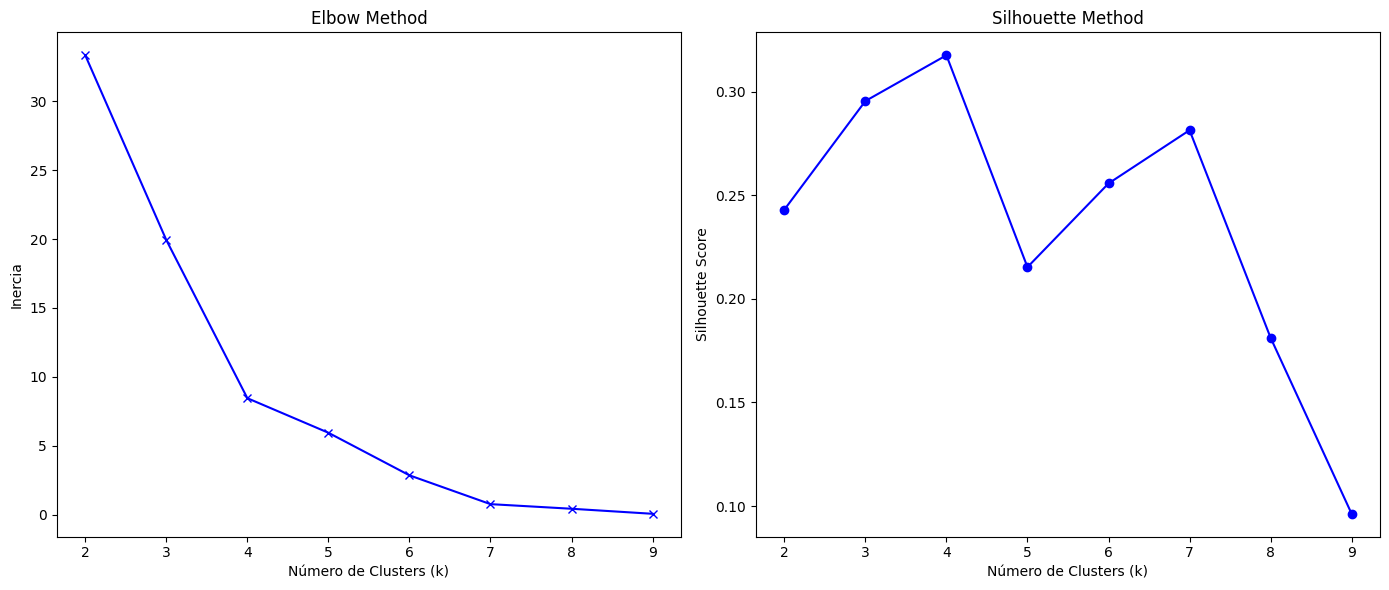

In [13]:
from modules import kmeans_module as km_m

km_m.plot_elbow_silhouette(scaled_df, 9)

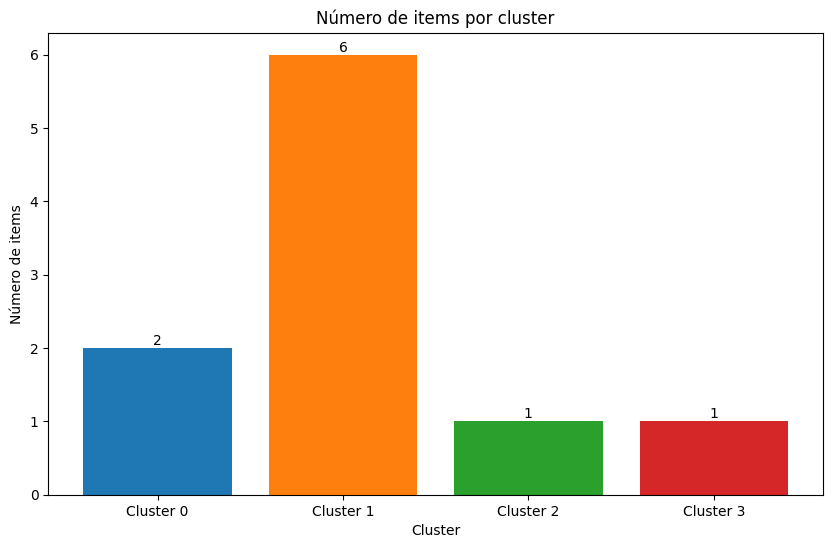

,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),Cluster
store_code,,,,,
NYC_1,4153.32,51.929222,0.07,89.614280,1
NYC_2,1613.52,45.315173,0.24,58.430267,2
NYC_3,8623.37,71.507726,0.01,130.058981,3
NYC_4,1744.99,31.187712,0.04,42.174182,0
BOS_1,2219.70,38.995716,0.12,66.422400,1


In [14]:
# Apreciamos varias opciones 4
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

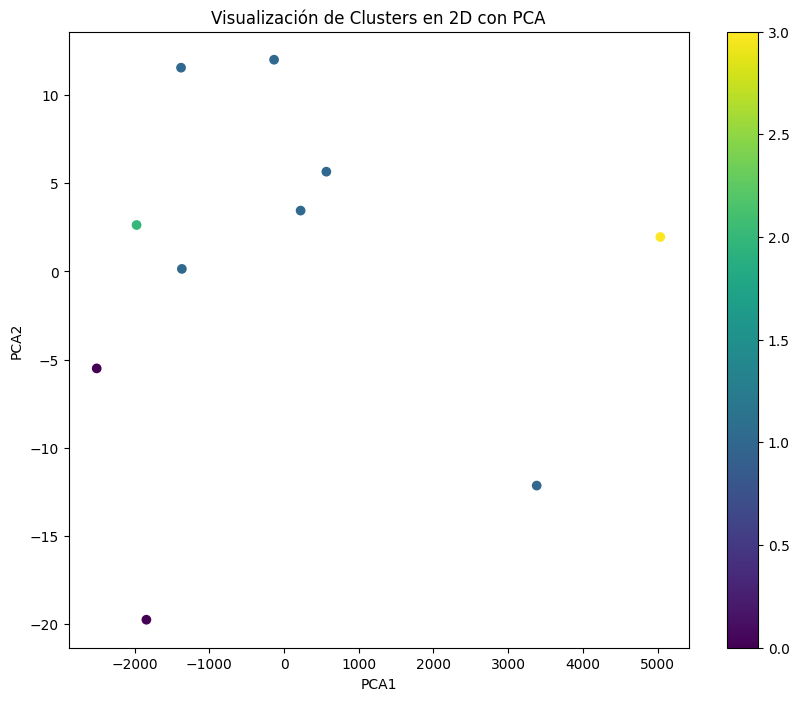

,PCA1,PCA2,Cluster
0,566.001726,5.663290,1
1,-1973.992834,2.635494,2
2,5036.271777,1.955547,3
3,-1842.750447,-19.773525,0
4,-1367.788704,0.143251,1


In [15]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99997928])

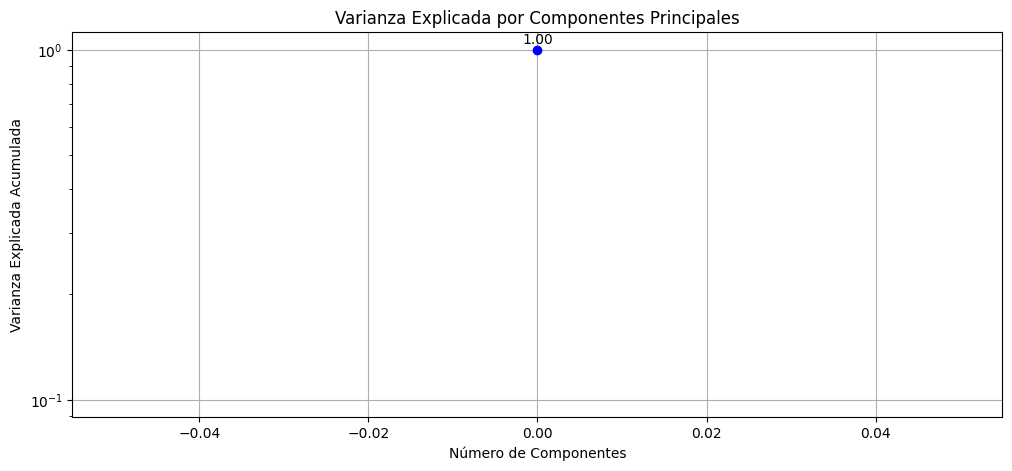

In [16]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

### Importancia caracteristicas

Cat cols: 0
Num cols: 4


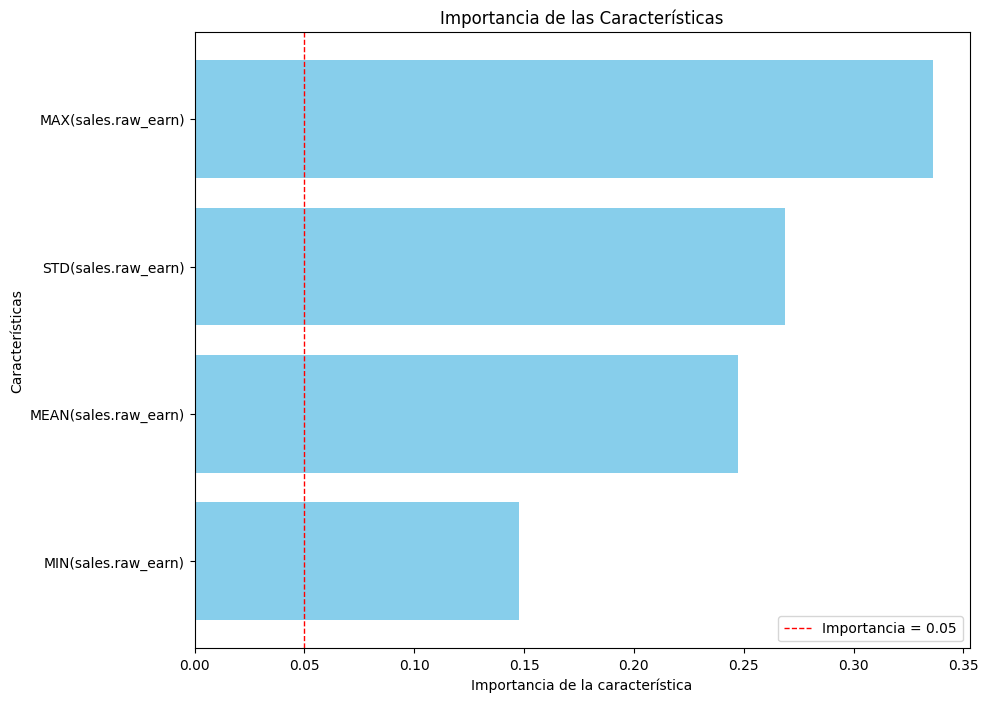

,Feature,Importance
0,MAX(sales.raw_earn),0.335985
1,STD(sales.raw_earn),0.268909
2,MEAN(sales.raw_earn),0.247558
3,MIN(sales.raw_earn),0.147548


In [17]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dim redux

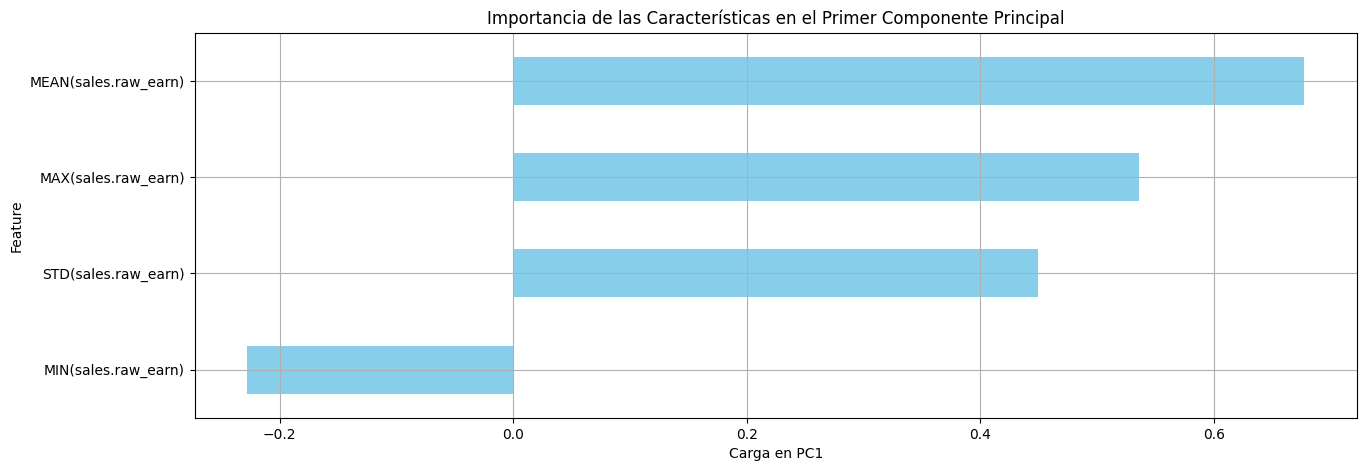

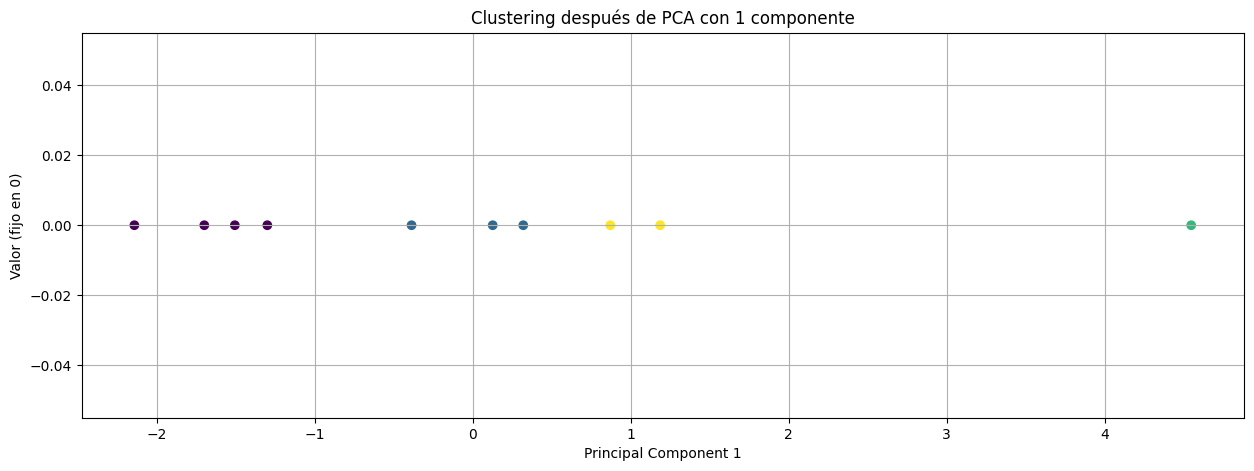

In [18]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion de clusters

,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),PC1,Cluster
0,0.596752,0.908654,0.000000,0.265447,0.869518,3
1,-0.554384,0.044804,3.090909,-0.784661,-1.508221,0
2,2.622752,3.465769,-1.090909,1.627404,4.548206,2
3,-0.494796,-1.800360,-0.545455,-1.332077,-2.144431,0
4,-0.279639,-0.780570,0.909091,-0.515529,-1.302517,0


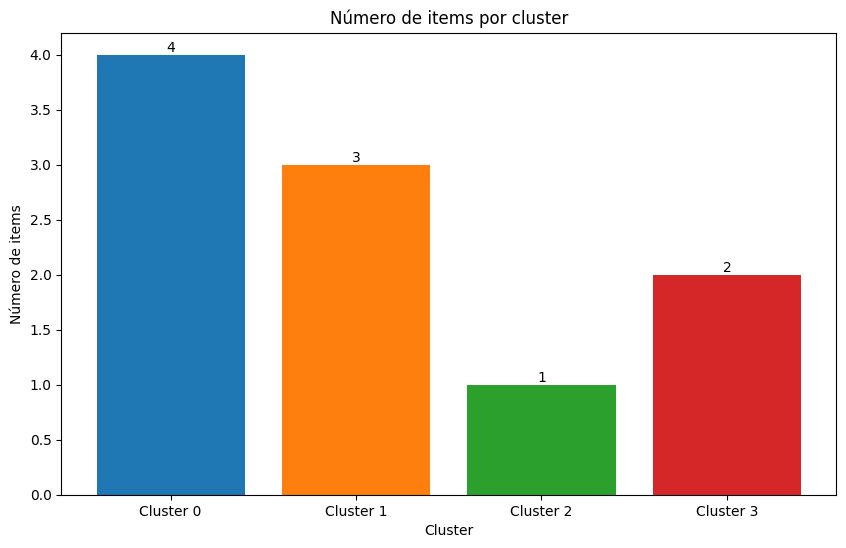

In [19]:
# Ejecutar PCA y clustering
optimal_k = 4
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [20]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,3,0,2,1
MEAN(sales.raw_earn),0.431925,-0.904585,3.465769,0.060299
MAX(sales.raw_earn),1.234718,-0.531259,2.622752,0.145151
STD(sales.raw_earn),0.574433,-0.948582,1.627404,0.096116


In [21]:
description_df[sorted(description_df.columns)]

,0,1,2,3
MEAN(sales.raw_earn),-0.904585,0.060299,3.465769,0.431925
MAX(sales.raw_earn),-0.531259,0.145151,2.622752,1.234718
STD(sales.raw_earn),-0.948582,0.096116,1.627404,0.574433


In [22]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,3
1,NYC_2,New York,Harlem,0
2,NYC_3,New York,Tribeca,2
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,0


In [23]:
# ordenar este df por cluster ascendente
df_shops_with_clusters = df_shops_with_clusters.sort_values(by='Cluster')
df_shops_with_clusters # ordenar por cluster


,store_code,region,store,Cluster
1,NYC_2,New York,Harlem,0
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,0
7,PHI_1,Philadelphia,Midtown_Village,0
5,BOS_2,Boston,Roxbury,1
8,PHI_2,Philadelphia,Yorktown,1
9,PHI_3,Philadelphia,Queen_Village,1
2,NYC_3,New York,Tribeca,2
0,NYC_1,New York,Greenwich_Village,3
6,BOS_3,Boston,Back_Bay,3


In [24]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Low Performance Stores',
        'description': 'Tiendas con ingresos consistentemente bajos y una desviación estándar relativamente alta, lo que indica variabilidad en sus ventas. Estas tiendas tienen ingresos máximos por debajo del promedio, lo que sugiere que no tienen picos de ventas significativos.'
    },
    1: {
        'cluster_name': 'Stable Low Earners',
        'description': 'Tiendas con ingresos bajos pero estables, como lo muestra la baja desviación estándar. Aunque los ingresos máximos y promedio son bajos, la estabilidad indica una clientela constante, sin grandes fluctuaciones.'
    },
    2: {
        'cluster_name': 'High Earners with Variability',
        'description': 'Tiendas con ingresos promedios altos y picos significativos de ventas, pero con una considerable variabilidad en sus ingresos, lo que sugiere dependencia de ciertos eventos o productos de alto rendimiento.'
    },
    3: {
        'cluster_name': 'Moderate Performers',
        'description': 'Tiendas con ingresos promedio moderados, junto con una desviación estándar media. Estas tiendas muestran una variabilidad limitada en sus ventas, lo que sugiere que tienen un rendimiento más predecible.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

shops_with_cluster_info = shops_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,cluster,cluster_name,description
1,NYC_2,New York,Harlem,0,Low Performance Stores,Tiendas con ingresos consistentemente bajos y ...
3,NYC_4,New York,Brooklyn,0,Low Performance Stores,Tiendas con ingresos consistentemente bajos y ...
4,BOS_1,Boston,South_End,0,Low Performance Stores,Tiendas con ingresos consistentemente bajos y ...
7,PHI_1,Philadelphia,Midtown_Village,0,Low Performance Stores,Tiendas con ingresos consistentemente bajos y ...
5,BOS_2,Boston,Roxbury,1,Stable Low Earners,"Tiendas con ingresos bajos pero estables, como..."


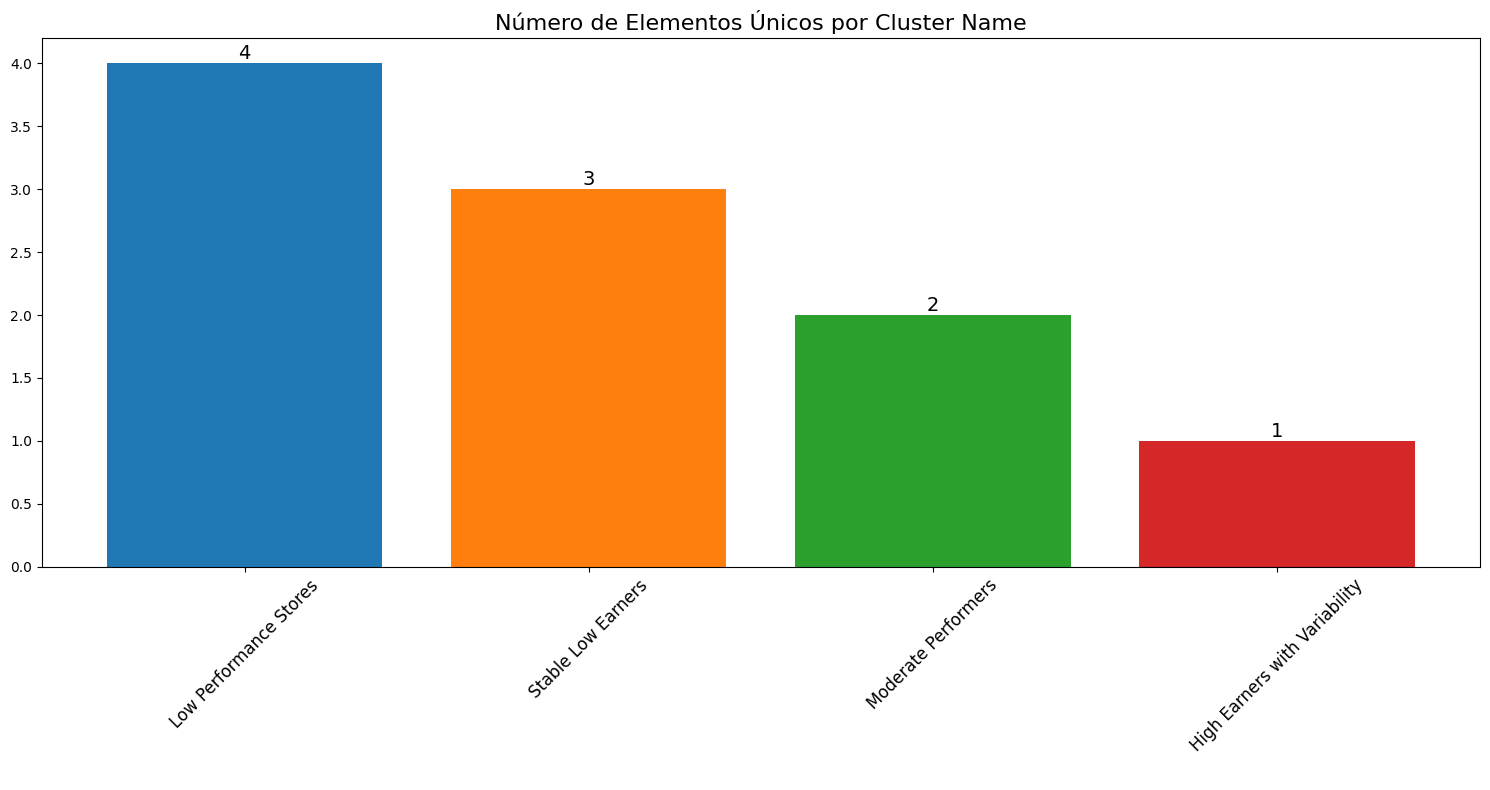

In [25]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardar CSV

In [26]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_global_sales_performance.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **MIX DE PRODUCTOS: Segun cluster performance ventas global**  
  
Esta configuración se centra en entender la variedad y popularidad de los productos en diferentes tiendas.
___
___

## Importacion de datos

In [27]:
df_items_sp_clusters = get_data('_clusters/items_clusters_raw_earn.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

# No vamos a usar eventos ahora
# # Añadir la columna 'event' a df_ws usando el método 'map'
# # Crear un diccionario desde df_cal
# event_dict = df_cal.set_index('week')['event'].to_dict()
# df_ws['event'] = df_ws['week'].map(event_dict)

# # Rellenar NaN columna event de df_ws con 'None' (str)
# df_ws['event'] = df_ws['event'].fillna('None')

In [28]:
display(df_items_sp_clusters.head())
display(df_shops.head())
display(df_ws.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,Moderate Performers,"Productos con ingresos medios y estables, con ..."
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32


In [29]:
# ONE HOT ENCODING DE LOS CLUSTERS - PARA EVITAR CREAR CARACTERISTICAS NUMERICAS BASADAS EN ELLOS
# Guardamos los nombres y definiciones de los clusters aparte para trabajar solo con la columna Cluster de productos
# Crear el diccionario de nombres y descripciones de clusters
cluster_dict = df_items_sp_clusters[['Cluster', 'cluster_name', 'description']].drop_duplicates().set_index('Cluster').to_dict('index')

df_items_ohe = df_items_sp_clusters.copy()

# Hacer OHE usando scikit learn
from sklearn.preprocessing import OneHotEncoder
df_items_ohe = df_items_ohe.drop(columns=['Cluster', 'description'])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_items_ohe = ohe.fit_transform(df_items_ohe[['cluster_name']])
df_items_ohe = pd.DataFrame(df_items_ohe, columns=ohe.get_feature_names_out(['cluster_name']))
df_items_ohe = pd.concat([df_items_sp_clusters[['item']], df_items_ohe], axis=1)

display(df_items_ohe.head())

,item,cluster_name_High Performers,cluster_name_Moderate Performers,cluster_name_Top Performers with High Variability,cluster_name_Underperformers
0,ACCESORIES_1_001,0.0,0.0,0.0,1.0
1,ACCESORIES_1_002,0.0,0.0,0.0,1.0
2,ACCESORIES_1_003,0.0,0.0,0.0,1.0
3,ACCESORIES_1_004,0.0,1.0,0.0,0.0
4,ACCESORIES_1_005,0.0,0.0,0.0,1.0


## Seleccion / Creacion caracteristicas

In [30]:
# Creacion caracteristicas globales para tiendas (luego iremos filtrando)
fc_config = {
    'target_df': 'shops',  # El DataFrame que contiene información sobre las tiendas
    'agg_primitives': [
        'mean',              # Promedio
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        'percentile'
    ],
    'max_depth': 2  # Profundidad máxima de las características generadas
}

feature_matrix, feature_defs = fcm.create_features(df_items_ohe, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [31]:
feature_matrix.head()

,COUNT(sales),MEAN(sales.raw_earn),MEAN(sales.sell_price),MEAN(sales.units),MEAN(sales.week),MEAN(sales.year),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),...,PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.sell_price)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MEAN(sales.week)),PERCENTILE(MEAN(sales.year)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.sell_price)),PERCENTILE(SUM(sales.units)),PERCENTILE(SUM(sales.week)),PERCENTILE(SUM(sales.year))
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,51.929222,5.392711,14.413409,25.952865,2013.528791,27735449.19,2880252.29,7698216.0,13861451.0,...,0.9,0.9,0.9,0.5,0.4,0.9,0.9,0.9,0.9,0.9
NYC_2,474612,45.315173,5.466066,11.979206,26.073260,2013.605870,21507125.12,2594260.38,5685475.0,12374682.0,...,0.6,1.0,0.4,0.9,0.8,0.5,0.5,0.4,0.2,0.2
NYC_3,552278,71.507726,5.353441,20.258240,26.025523,2013.549663,39492143.82,2956587.60,11188180.0,14373324.0,...,1.0,0.7,1.0,0.8,0.6,1.0,1.0,1.0,1.0,1.0
NYC_4,482465,31.187712,5.299665,8.505645,25.996731,2013.549835,15046979.58,2556902.75,4103676.0,12542513.0,...,0.1,0.6,0.1,0.7,0.7,0.1,0.3,0.1,0.3,0.3
BOS_1,495985,38.995716,5.212343,11.281172,25.951962,2013.511169,19341290.34,2585243.70,5595292.0,12871784.0,...,0.3,0.2,0.3,0.4,0.3,0.3,0.4,0.3,0.6,0.6


In [32]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.units)>: The average of the "units" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.week)>: The average of the "week" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MEAN(sales.year)>: The average of the "year" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sales.raw_earn)>: The sum of the "raw_earn" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sales.sell_price)>: The sum of the "sell_price" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: SUM(sal

## Seleccion caracteristicas

In [33]:
# V3
substrings = substrings = [
    'items',
    'raw_earn',
    'sell_price',
    'cluster_name',
    'PERCENTILE'
]

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 33
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 33
Shape after filtering: 16
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performers),MEAN(sales.items.cluster_name_Moderate Performers),MEAN(sales.items.cluster_name_Top Performers with High Variability),SUM(sales.items.cluster_name_High Performers),SUM(sales.items.cluster_name_Moderate Performers),SUM(sales.items.cluster_name_Top Performers with High Variability),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price))
store_code,,,,,,,,,,,,,,,,
NYC_1,51.929222,5.392711,2880252.29,0.545948,0.499550,0.494924,0.047358,0.272553,0.002621,25294.0,145571.0,1400.0,0.9,0.9,0.9,0.9
NYC_2,45.315173,5.466066,2594260.38,0.529254,0.501663,0.510060,0.049678,0.272631,0.002804,23578.0,129394.0,1331.0,0.2,0.6,0.4,0.5
NYC_3,71.507726,5.353441,2956587.60,0.599604,0.500831,0.498926,0.048570,0.272088,0.002805,26824.0,150268.0,1549.0,1.0,1.0,1.0,1.0
NYC_4,31.187712,5.299665,2556902.75,0.437866,0.500351,0.499109,0.051336,0.287714,0.002806,24768.0,138812.0,1354.0,0.3,0.1,0.1,0.3
BOS_1,38.995716,5.212343,2585243.70,0.453500,0.499493,0.491865,0.051300,0.290634,0.002760,25444.0,144150.0,1369.0,0.6,0.3,0.3,0.4


## Preprocesamiento datos

In [34]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 16


,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performers),MEAN(sales.items.cluster_name_Moderate Performers),MEAN(sales.items.cluster_name_Top Performers with High Variability),SUM(sales.items.cluster_name_High Performers),SUM(sales.items.cluster_name_Moderate Performers),SUM(sales.items.cluster_name_Top Performers with High Variability),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price))
0,0.908654,0.883771,1.490961,1.121865,-0.231087,-0.248036,-1.155213,-0.543109,-1.769180,0.086467,0.465881,0.524194,0.777778,0.777778,0.777778,0.777778
1,0.044804,1.525698,-0.006368,0.801667,1.151989,0.782157,-0.283392,-0.537603,0.242945,-1.459131,-1.058812,-0.588710,-0.777778,0.111111,-0.333333,-0.111111
2,3.465769,0.540119,1.890619,2.150999,0.607515,0.024358,-0.699967,-0.576071,0.246800,1.464535,0.908577,2.927419,1.000000,1.000000,1.000000,1.000000
3,-1.800360,0.069526,-0.201956,-0.951202,0.293017,0.036781,0.339514,0.529926,0.265192,-0.387300,-0.171159,-0.217742,-0.555556,-1.000000,-1.000000,-0.555556
4,-0.780570,-0.694630,-0.053575,-0.651341,-0.268662,-0.456237,0.325827,0.736570,-0.242945,0.221572,0.331951,0.024194,0.111111,-0.555556,-0.555556,-0.333333


## Kmeans

### Elbow & Silhoutte

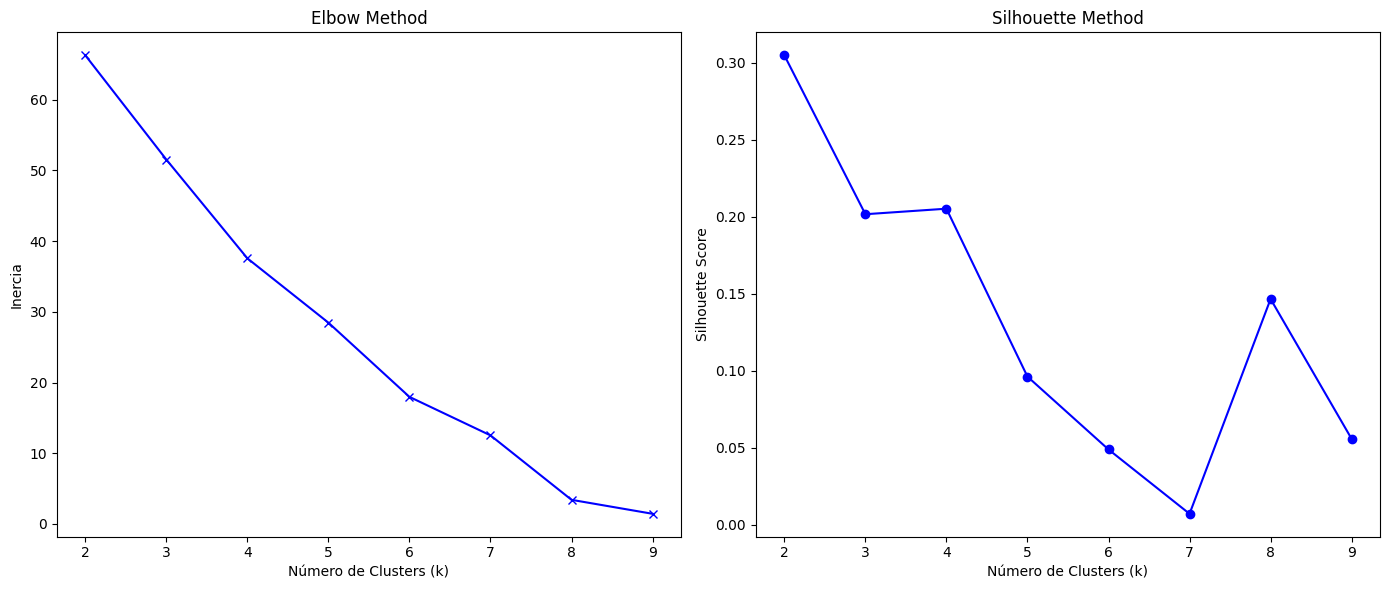

In [39]:
km_m.plot_elbow_silhouette(scaled_df, 9)

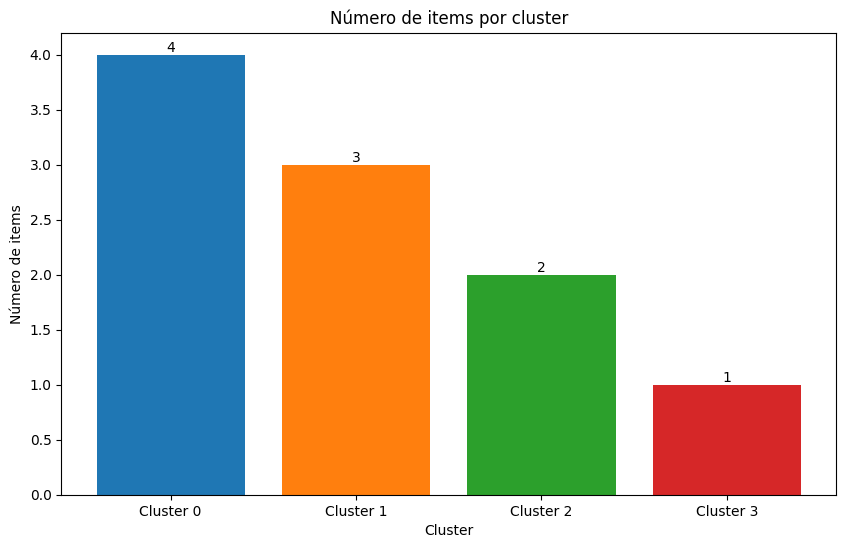

,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performers),MEAN(sales.items.cluster_name_Moderate Performers),MEAN(sales.items.cluster_name_Top Performers with High Variability),SUM(sales.items.cluster_name_High Performers),SUM(sales.items.cluster_name_Moderate Performers),SUM(sales.items.cluster_name_Top Performers with High Variability),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price)),Cluster
store_code,,,,,,,,,,,,,,,,,
NYC_1,51.929222,5.392711,2880252.29,0.545948,0.499550,0.494924,0.047358,0.272553,0.002621,25294.0,145571.0,1400.0,0.9,0.9,0.9,0.9,1
NYC_2,45.315173,5.466066,2594260.38,0.529254,0.501663,0.510060,0.049678,0.272631,0.002804,23578.0,129394.0,1331.0,0.2,0.6,0.4,0.5,2
NYC_3,71.507726,5.353441,2956587.60,0.599604,0.500831,0.498926,0.048570,0.272088,0.002805,26824.0,150268.0,1549.0,1.0,1.0,1.0,1.0,1
NYC_4,31.187712,5.299665,2556902.75,0.437866,0.500351,0.499109,0.051336,0.287714,0.002806,24768.0,138812.0,1354.0,0.3,0.1,0.1,0.3,0
BOS_1,38.995716,5.212343,2585243.70,0.453500,0.499493,0.491865,0.051300,0.290634,0.002760,25444.0,144150.0,1369.0,0.6,0.3,0.3,0.4,0


In [35]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

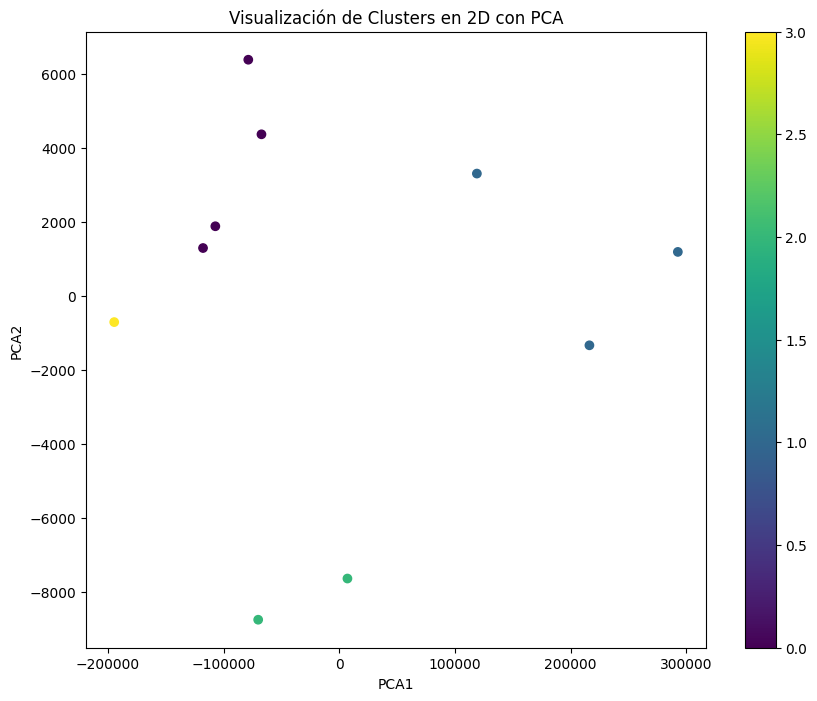

,PCA1,PCA2,Cluster
0,216309.733847,-1334.179422,1
1,-70047.911082,-8751.319230,2
2,292758.349901,1190.223916,1
3,-107094.809894,1883.663223,0
4,-78601.316466,6384.748116,0


In [36]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99904505])

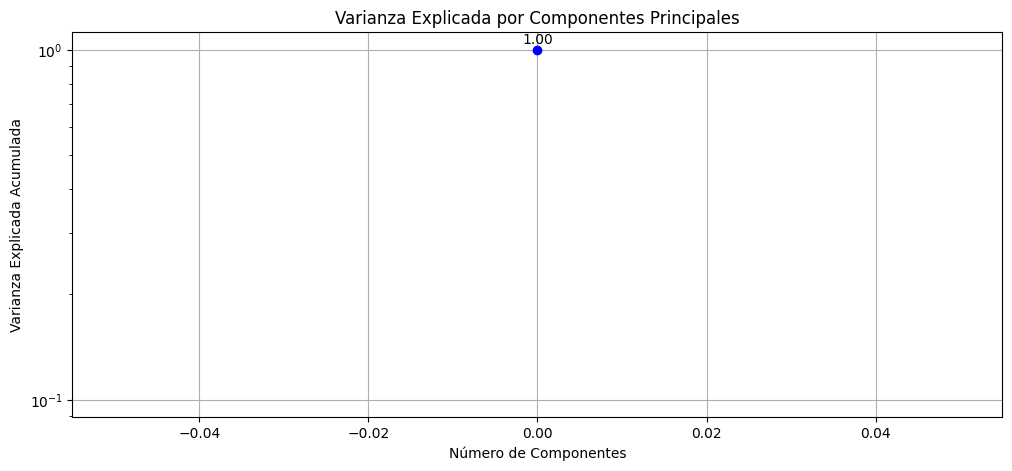

In [37]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

### Importancia caracteristicas

Cat cols: 0
Num cols: 16


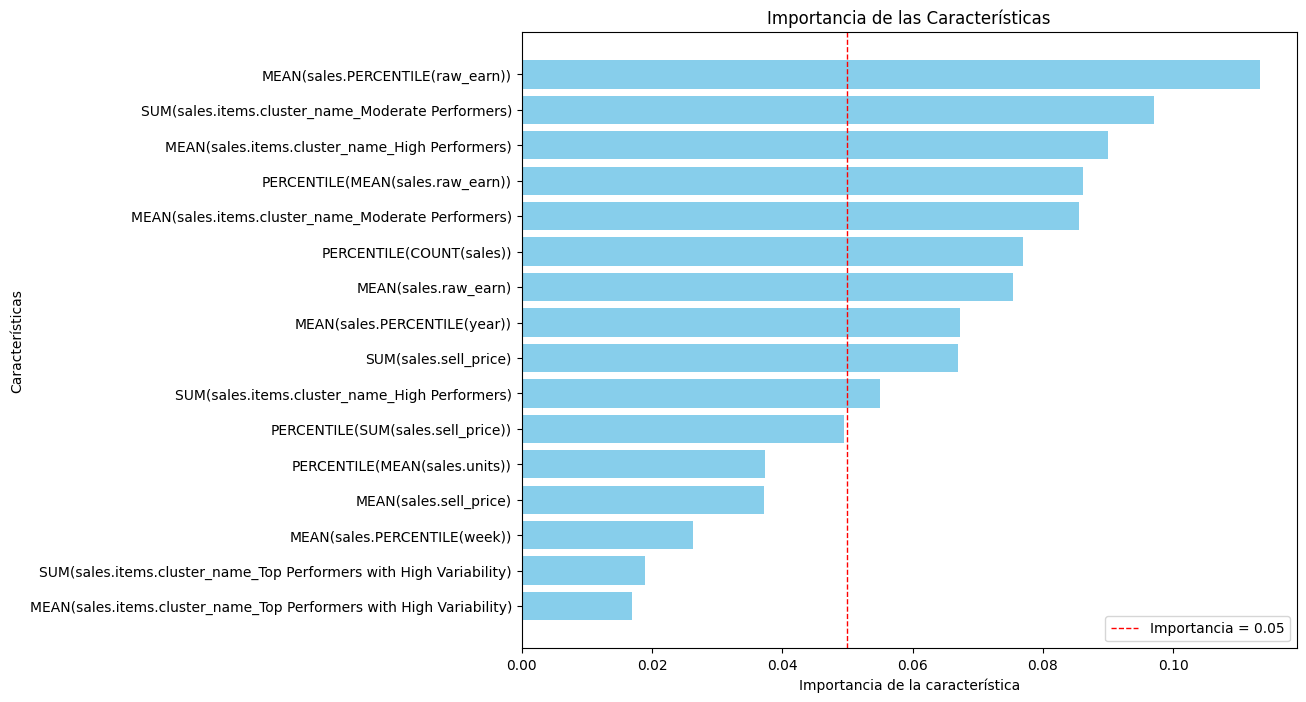

,Feature,Importance
0,MEAN(sales.PERCENTILE(raw_earn)),0.113294
1,SUM(sales.items.cluster_name_Moderate Performers),0.097131
2,MEAN(sales.items.cluster_name_High Performers),0.090038
3,PERCENTILE(MEAN(sales.raw_earn)),0.086105
4,MEAN(sales.items.cluster_name_Moderate Perform...,0.085514
5,PERCENTILE(COUNT(sales)),0.076953
6,MEAN(sales.raw_earn),0.075478
7,MEAN(sales.PERCENTILE(year)),0.067251
8,SUM(sales.sell_price),0.067006
9,SUM(sales.items.cluster_name_High Performers),0.055047


In [38]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

## Dim redux

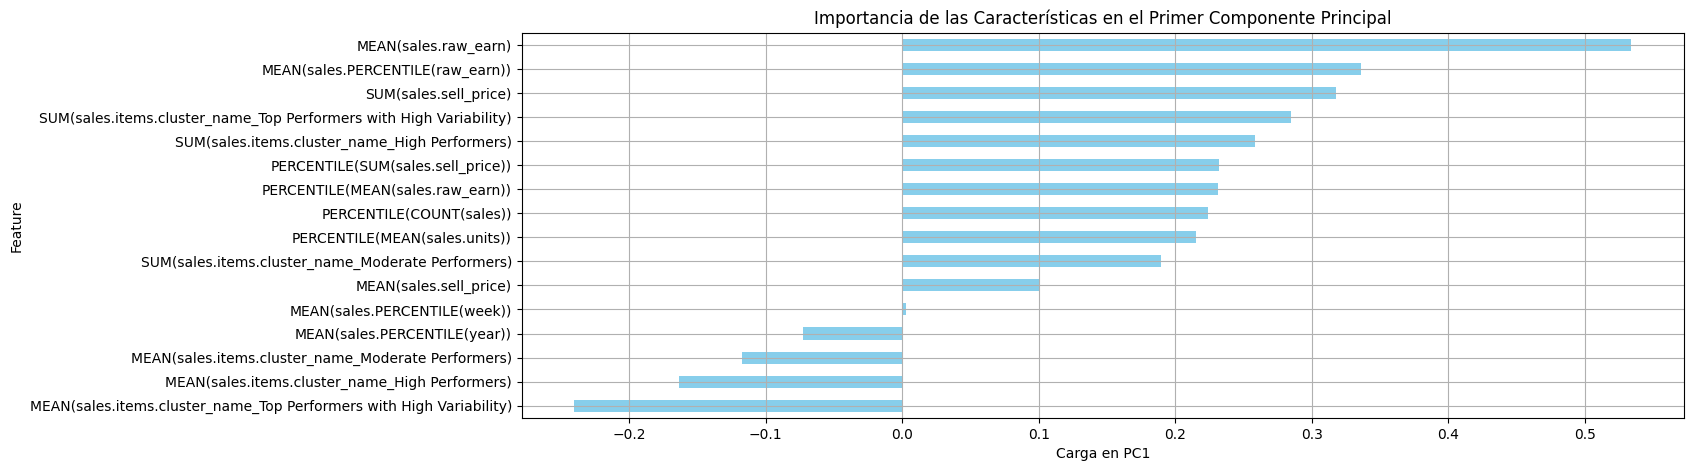

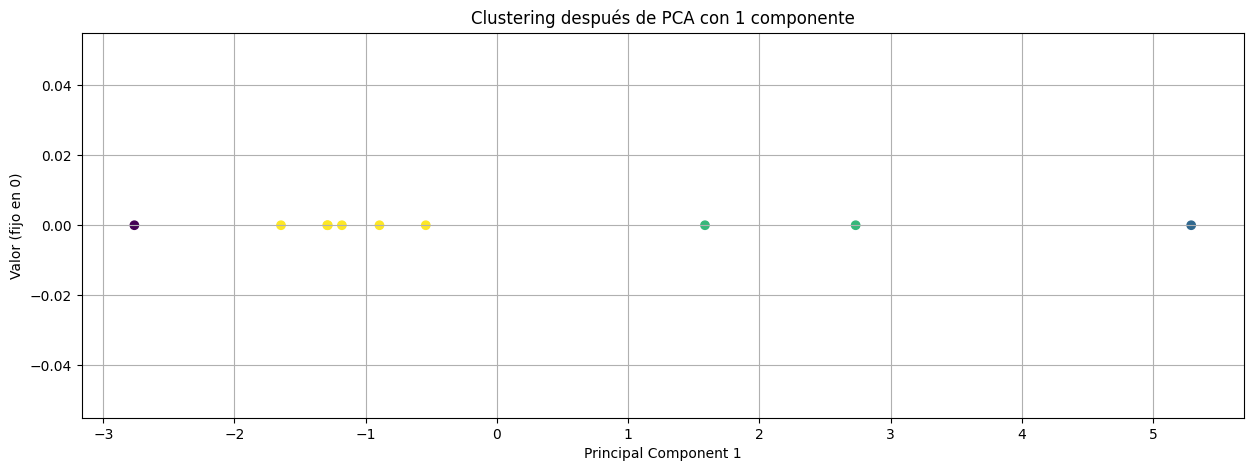

In [39]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion de clusters

,MEAN(sales.raw_earn),MEAN(sales.sell_price),SUM(sales.sell_price),MEAN(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(week)),MEAN(sales.PERCENTILE(year)),MEAN(sales.items.cluster_name_High Performers),MEAN(sales.items.cluster_name_Moderate Performers),MEAN(sales.items.cluster_name_Top Performers with High Variability),SUM(sales.items.cluster_name_High Performers),SUM(sales.items.cluster_name_Moderate Performers),SUM(sales.items.cluster_name_Top Performers with High Variability),PERCENTILE(COUNT(sales)),PERCENTILE(MEAN(sales.raw_earn)),PERCENTILE(MEAN(sales.units)),PERCENTILE(SUM(sales.sell_price)),PC1,Cluster
0,0.908654,0.883771,1.490961,1.121865,-0.231087,-0.248036,-1.155213,-0.543109,-1.769180,0.086467,0.465881,0.524194,0.777778,0.777778,0.777778,0.777778,2.733599,2
1,0.044804,1.525698,-0.006368,0.801667,1.151989,0.782157,-0.283392,-0.537603,0.242945,-1.459131,-1.058812,-0.588710,-0.777778,0.111111,-0.333333,-0.111111,-0.895201,3
2,3.465769,0.540119,1.890619,2.150999,0.607515,0.024358,-0.699967,-0.576071,0.246800,1.464535,0.908577,2.927419,1.000000,1.000000,1.000000,1.000000,5.290595,1
3,-1.800360,0.069526,-0.201956,-0.951202,0.293017,0.036781,0.339514,0.529926,0.265192,-0.387300,-0.171159,-0.217742,-0.555556,-1.000000,-1.000000,-0.555556,-2.763023,0
4,-0.780570,-0.694630,-0.053575,-0.651341,-0.268662,-0.456237,0.325827,0.736570,-0.242945,0.221572,0.331951,0.024194,0.111111,-0.555556,-0.555556,-0.333333,-1.293253,3


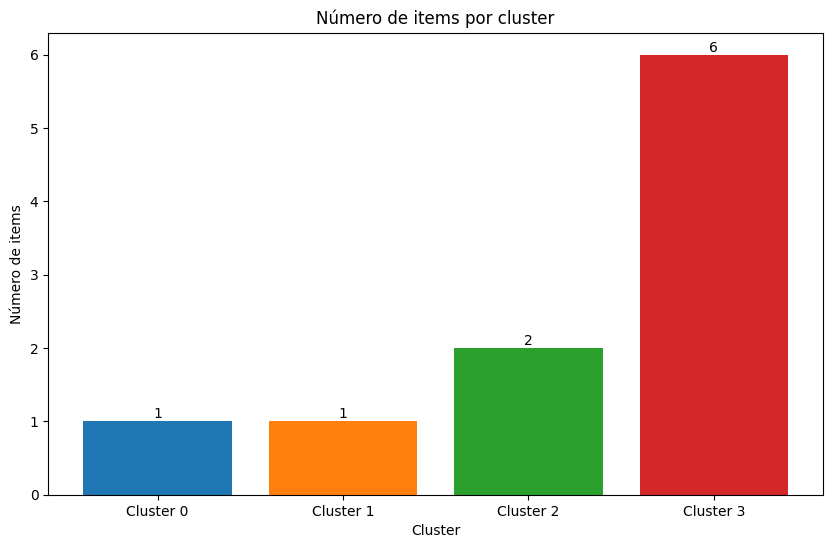

In [40]:
# Ejecutar PCA y clustering
optimal_k = 4
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [41]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,1,2,3
MEAN(sales.raw_earn),-1.800360,3.465769,0.650335,-0.345651
MEAN(sales.PERCENTILE(raw_earn)),-0.951202,2.150999,0.686163,-0.080033
SUM(sales.sell_price),-0.201956,1.890619,1.236033,-0.095482
SUM(sales.items.cluster_name_Top Performers with High Variability),-0.217742,2.927419,0.250000,0.139785
SUM(sales.items.cluster_name_High Performers),-0.387300,1.464535,0.306688,-0.556932
PERCENTILE(SUM(sales.sell_price)),-0.555556,1.000000,0.666667,-0.296296
PERCENTILE(MEAN(sales.raw_earn)),-1.000000,1.000000,0.666667,-0.222222
PERCENTILE(COUNT(sales)),-0.555556,1.000000,0.666667,-0.296296
PERCENTILE(MEAN(sales.units)),-1.000000,1.000000,0.555556,-0.185185
SUM(sales.items.cluster_name_Moderate Performers),-0.171159,0.908577,0.540434,-0.368662


In [48]:
# Añadimos clusters a df_items
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,2
1,NYC_2,New York,Harlem,3
2,NYC_3,New York,Tribeca,1
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,3


In [49]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Underperforming Stores',
        'description': 'Tiendas con bajo desempeño en ventas, tanto en ingresos como en la venta de productos de alto rendimiento. Estas tiendas tienen un precio de venta promedio cercano al promedio, pero muestran una fuerte caída en la venta de productos premium y de alto rendimiento.'
    },
    1: {
        'cluster_name': 'Top-Performing Stores',
        'description': 'Tiendas con el mejor desempeño en ventas, generando ingresos y vendiendo productos de alto rendimiento en grandes cantidades. Estas tiendas también muestran un excelente desempeño en la venta de productos con alta variabilidad, lo que sugiere un mix diverso de productos.'
    },
    2: {
        'cluster_name': 'Moderate-Performance Stores',
        'description': 'Tiendas con un desempeño moderado en ventas, con ingresos y precios de venta cercanos al promedio. Estas tiendas venden tanto productos de alto rendimiento como productos con variabilidad moderada, lo que indica un mix de productos equilibrado.'
    },
    3: {
        'cluster_name': 'Low-Variance, Low Performance Stores',
        'description': 'Tiendas con bajo rendimiento en ventas y con una baja variabilidad en la venta de productos. Estas tiendas no dependen de productos de alto rendimiento y muestran una estabilidad general en sus ventas, aunque a un nivel bajo.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

shops_with_cluster_info = shops_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `shops_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,2,Moderate-Performance Stores,"Tiendas con un desempeño moderado en ventas, c..."
1,NYC_2,New York,Harlem,3,"Low-Variance, Low Performance Stores",Tiendas con bajo rendimiento en ventas y con u...
2,NYC_3,New York,Tribeca,1,Top-Performing Stores,"Tiendas con el mejor desempeño en ventas, gene..."
3,NYC_4,New York,Brooklyn,0,Underperforming Stores,"Tiendas con bajo desempeño en ventas, tanto en..."
4,BOS_1,Boston,South_End,3,"Low-Variance, Low Performance Stores",Tiendas con bajo rendimiento en ventas y con u...


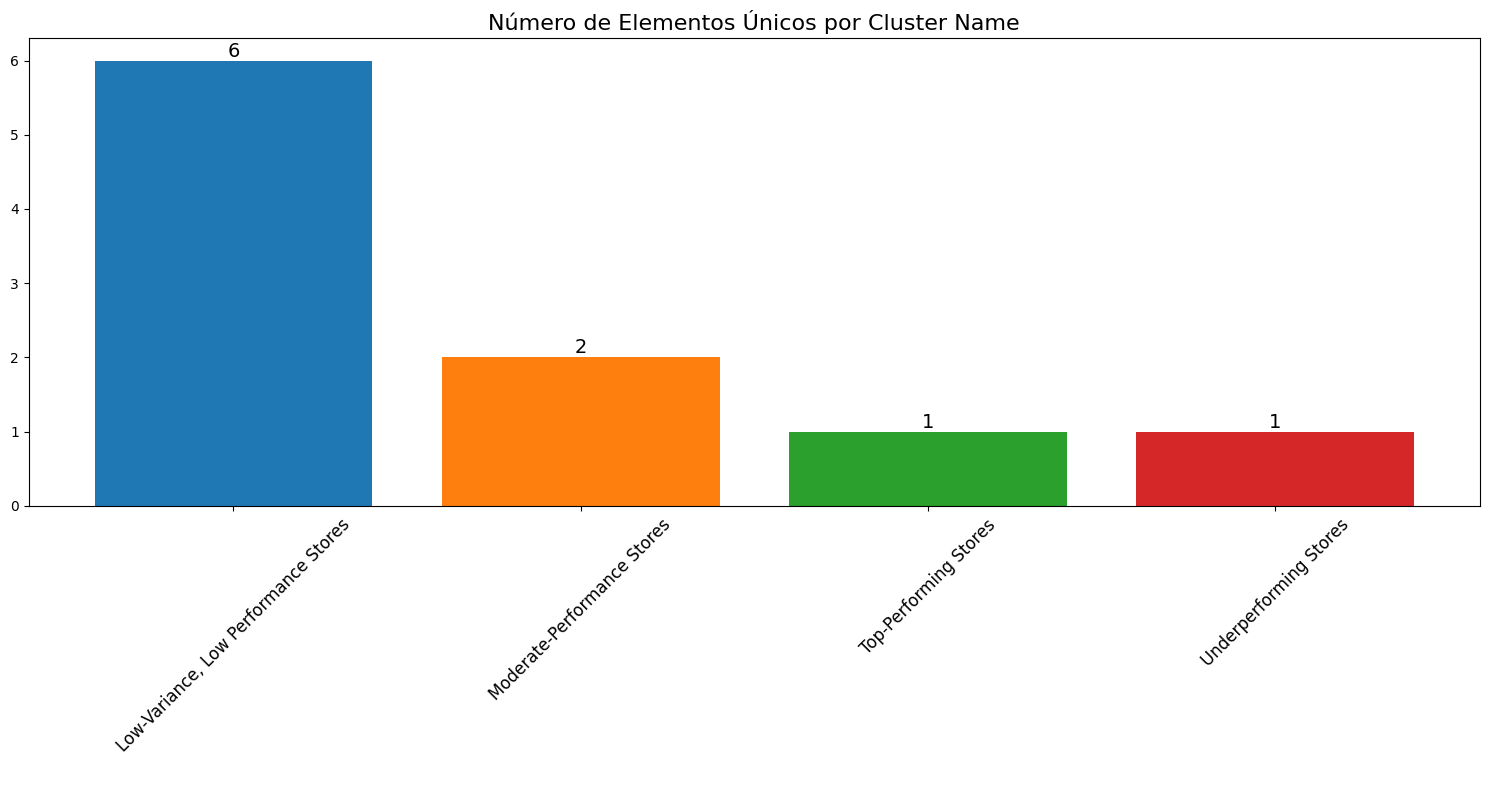

In [50]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardar CSV

In [51]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_products_mix.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **TIENDAS: SALES w EVENTS**
___
___

In [42]:
# Carga de datos para darles la forma que necesitamos
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')

# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

# Añadir la columna 'event' a df_ws usando el método 'map'
# Crear un diccionario desde df_cal
event_dict = df_cal.set_index('week')['event'].to_dict()
df_ws['event'] = df_ws['week'].map(event_dict)

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event,year,week
0,2011-02-06,SuperBowl,2011,5
1,2011-08-01,Ramadan starts,2011,31
2,2011-11-24,Thanksgiving,2011,47
3,2012-01-01,NewYear,2012,52
4,2012-02-05,SuperBowl,2012,5


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn,event
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32,None
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18,None
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95,None
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54,None
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32,None


## Creacion caracteristicas

In [43]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)



In [44]:
display(df_ws_ohe.head())

,item,store_code,year,week,units,sell_price,raw_earn,event,event_Easter,event_NewYear,event_None,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32,None,0.0,0.0,1.0,0.0,0.0,0.0
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18,None,0.0,0.0,1.0,0.0,0.0,0.0
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95,None,0.0,0.0,1.0,0.0,0.0,0.0
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54,None,0.0,0.0,1.0,0.0,0.0,0.0
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32,None,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
# Seteamos index de df_shops a columna store_code
# df_shops.set_index('store_code', inplace=True)
df_shops.head()

,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


In [46]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",)
                      # secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="shops",  # Objetivo: productos
                                      agg_primitives=[
                                          'min',               # Mínimo
                                          'max',               # Máximo
                                          'mean',              # Promedio
                                          'std',               # Desviación estándar
                                          'sum',               # Suma
                                          'count'              # Totales
                                      ],
                                      trans_primitives=[
                                          'month',  # Extrae el mes para observar patrones estacionales a nivel semanal
                                          'is_weekend'  # Indica si la semana incluye fines de semana
                                      ],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head(10)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

,COUNT(sales),MAX(sales.event_Easter),MAX(sales.event_NewYear),MAX(sales.event_None),MAX(sales.event_Ramadan starts),MAX(sales.event_SuperBowl),MAX(sales.event_Thanksgiving),MAX(sales.raw_earn),MAX(sales.sell_price),MAX(sales.units),...,SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.year)
store_code,,,,,,,,,,,,,,,,,,,,,
NYC_1,534101,1.0,1.0,1.0,1.0,1.0,1.0,4153.32,41.20,1697.0,...,24208.0,383510.0,48610.0,11297.0,19167.0,27735449.19,2880252.29,7698216.0,13861451.0,1.075428e+09
NYC_2,474612,1.0,1.0,1.0,1.0,1.0,1.0,1613.52,41.20,638.0,...,22342.0,340162.0,42457.0,10125.0,17402.0,21507125.12,2594260.38,5685475.0,12374682.0,9.556815e+08
NYC_3,552278,1.0,1.0,1.0,1.0,1.0,1.0,8623.37,41.20,3976.0,...,25413.0,396934.0,49363.0,11697.0,20217.0,39492143.82,2956587.60,11188180.0,14373324.0,1.112039e+09
NYC_4,482465,1.0,1.0,1.0,1.0,1.0,1.0,1744.99,41.20,567.0,...,21688.0,346615.0,43418.0,10235.0,17571.0,15046979.58,2556902.75,4103676.0,12542513.0,9.714673e+08
BOS_1,495985,1.0,1.0,1.0,1.0,1.0,1.0,2219.70,65.77,1676.0,...,22053.0,356953.0,44488.0,10617.0,17956.0,19341290.34,2585243.70,5595292.0,12871784.0,9.986713e+08
BOS_2,526682,1.0,1.0,1.0,1.0,1.0,1.0,3453.66,38.52,2076.0,...,23648.0,378785.0,47207.0,11167.0,18899.0,25266833.17,2782869.17,7214384.0,13656819.0,1.060475e+09
BOS_3,491769,1.0,1.0,1.0,1.0,1.0,1.0,6968.46,41.20,1215.0,...,22167.0,353750.0,43684.0,10604.0,17925.0,21947204.50,2596692.90,6089330.0,12783517.0,9.901994e+08
PHI_1,497065,1.0,1.0,1.0,1.0,1.0,1.0,1079.95,44.85,690.0,...,23609.0,355522.0,43980.0,10623.0,18687.0,18235414.81,2671350.29,5149062.0,12885073.0,1.000916e+09
PHI_2,470736,1.0,1.0,1.0,1.0,1.0,1.0,3808.76,76.83,1161.0,...,21514.0,338850.0,42202.0,10031.0,17117.0,21658583.43,2469603.66,6544012.0,12283659.0,9.478872e+08


In [47]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: COUNT(sales)>: The number of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Easter)>: The maximum of the "event_Easter" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_NewYear)>: The maximum of the "event_NewYear" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_None)>: The maximum of the "event_None" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Ramadan starts)>: The maximum of the "event_Ramadan starts" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_SuperBowl)>: The maximum of the "event_SuperBowl" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.event_Thanksgiving)>: The maximum of the "event_Thanksgiving" of all instances of "sales" for each "store_code" in "shops".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of t

## Seleccion caracteristicas

In [48]:
# V3
substrings = ['raw_earn', 'event'] # Nos quedamos solo con las que afectan a ventas y eventos

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 56
Length Feats Selected: 35
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 35
Shape after filtering: 12
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear)
store_code,,,,,,,,,,,,
NYC_1,4153.32,0.088577,0.045325,0.718048,0.091013,0.021151,0.035886,51.929222,0.07,89.614280,47309.0,24208.0
NYC_2,1613.52,0.088755,0.047074,0.716716,0.089456,0.021333,0.036666,45.315173,0.24,58.430267,42124.0,22342.0
NYC_3,8623.37,0.088097,0.046015,0.718721,0.089381,0.021180,0.036607,71.507726,0.01,130.058981,48654.0,25413.0
NYC_4,1744.99,0.088997,0.044952,0.718425,0.089992,0.021214,0.036419,31.187712,0.04,42.174182,42938.0,21688.0
BOS_1,2219.70,0.088547,0.044463,0.719685,0.089696,0.021406,0.036203,38.995716,0.12,66.422400,43918.0,22053.0


## Preprocesamiento de los datos

In [49]:
from modules import preprocessing_module as pm

scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 12


,MAX(sales.raw_earn),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear)
0,0.596752,-0.288318,0.018362,-0.419124,2.624210,-0.884789,-1.355612,0.908654,0.000000,0.265447,1.020505,1.241047
1,-0.554384,0.013399,1.853154,-1.481161,-0.156028,0.062622,0.739378,0.044804,3.090909,-0.784661,-0.560409,0.042396
2,2.622752,-1.103102,0.742123,0.118106,-0.290920,-0.738232,0.580291,3.465769,-1.090909,1.627404,1.430597,2.015096
3,-0.494796,0.425127,-0.372069,-0.118106,0.800995,-0.558829,0.076640,-1.800360,-0.545455,-1.332077,-0.312219,-0.377710
4,-0.279639,-0.338988,-0.885381,0.886641,0.272713,0.441378,-0.505439,-0.780570,0.909091,-0.515529,-0.013416,-0.143247


## Kmeans

In [50]:
from modules import kmeans_module as km_m

### Elbow & Silouette

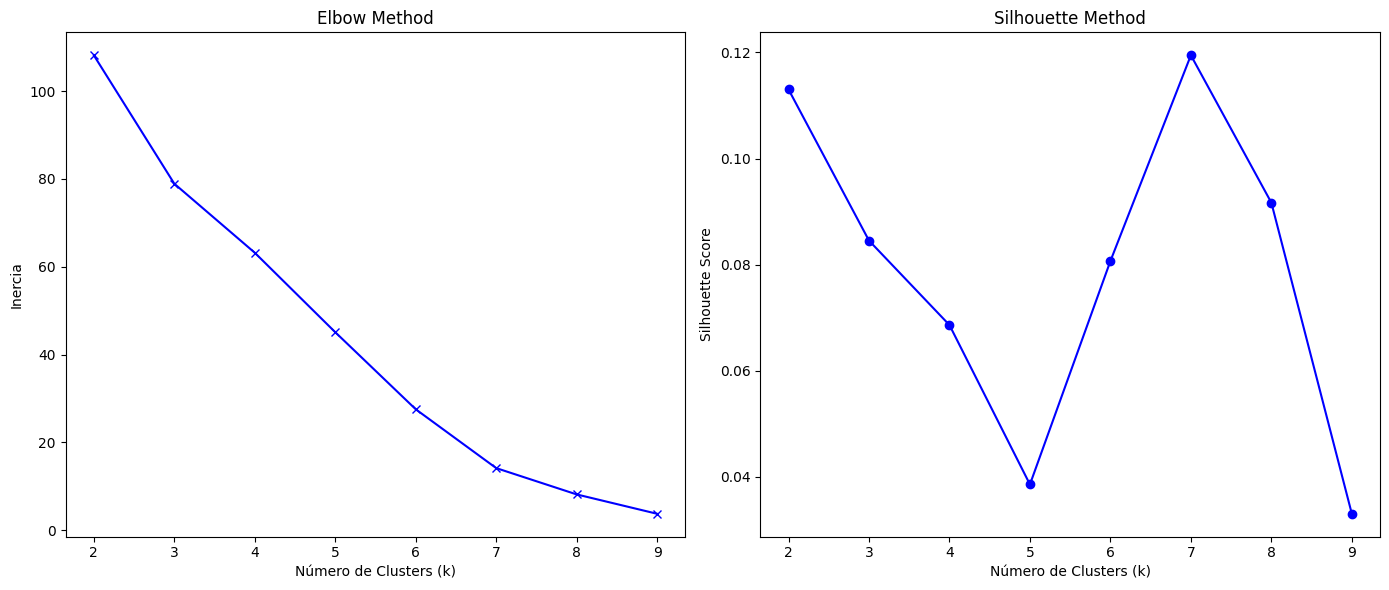

In [51]:
km_m.plot_elbow_silhouette(scaled_df, 9) # No podemos usar más de n_shops - 1

-   **Método del codo (Inercia)**: El gráfico de la izquierda muestra que la inercia disminuye significativamente hasta k=3. Después de eso, las disminuciones son menos pronunciadas, lo que indica un "codo" en k=3k = 3k=3.

-   **Método del coeficiente silhouette**: El gráfico de la derecha muestra que el puntaje del coeficiente silhouette es más alto en k=3, lo que sugiere que esta es la mejor opción en términos de cohesión y separación de clústeres.

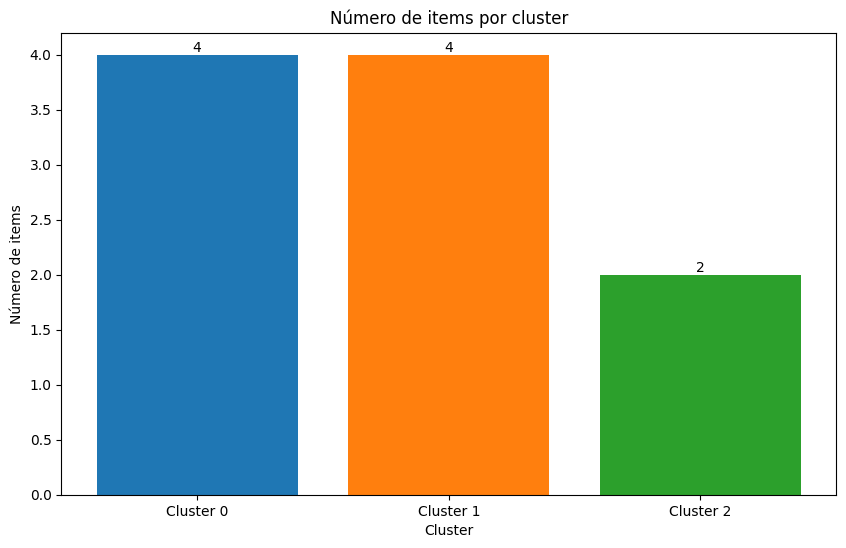

,MAX(sales.raw_earn),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),Cluster
store_code,,,,,,,,,,,,,
NYC_1,4153.32,0.088577,0.045325,0.718048,0.091013,0.021151,0.035886,51.929222,0.07,89.614280,47309.0,24208.0,0
NYC_2,1613.52,0.088755,0.047074,0.716716,0.089456,0.021333,0.036666,45.315173,0.24,58.430267,42124.0,22342.0,2
NYC_3,8623.37,0.088097,0.046015,0.718721,0.089381,0.021180,0.036607,71.507726,0.01,130.058981,48654.0,25413.0,1
NYC_4,1744.99,0.088997,0.044952,0.718425,0.089992,0.021214,0.036419,31.187712,0.04,42.174182,42938.0,21688.0,0
BOS_1,2219.70,0.088547,0.044463,0.719685,0.089696,0.021406,0.036203,38.995716,0.12,66.422400,43918.0,22053.0,0


In [52]:
optimal_k = 3 # Segun graficas

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

In [53]:
feature_matrix_with_clusters.shape

(10, 13)

### Analisis

#### PCAs

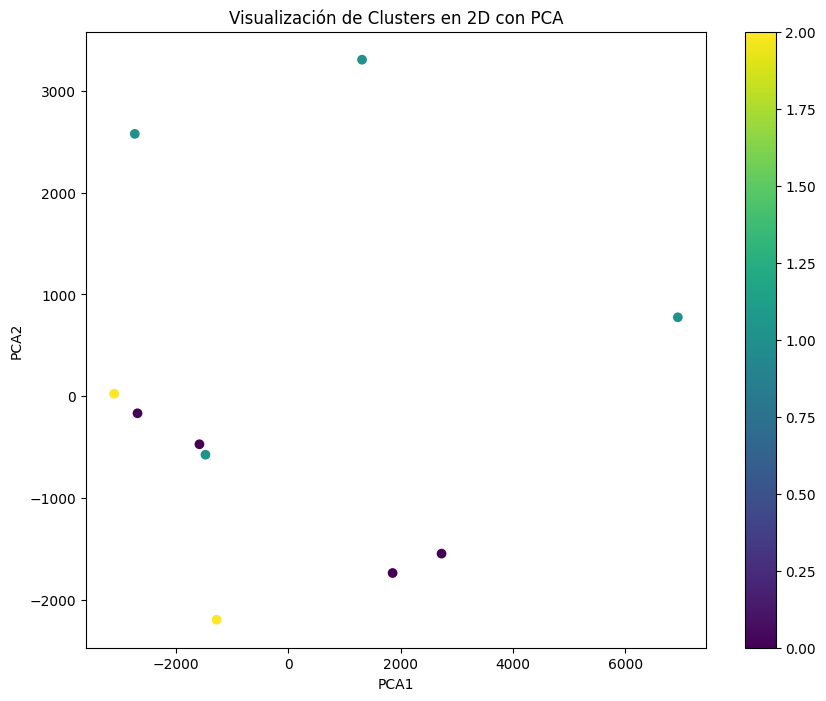

,PCA1,PCA2,Cluster
0,2728.685345,-1543.871659,0
1,-3096.312390,25.441898,2
2,6933.778218,775.476743,1
3,-2681.773243,-166.435968,0
4,-1579.807205,-470.378608,0


In [54]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 0.75
Principal Component 2: 0.24


array([0.74860438, 0.2373774 ])

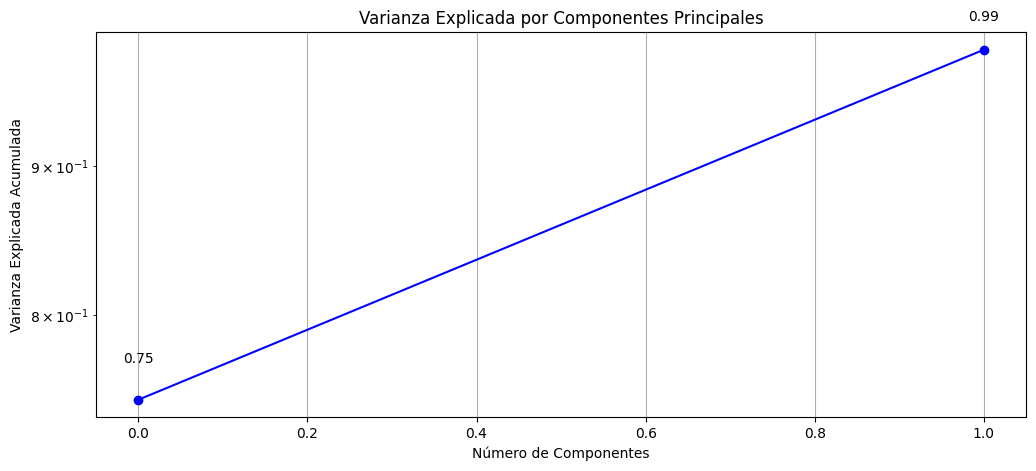

In [55]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 2)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 12


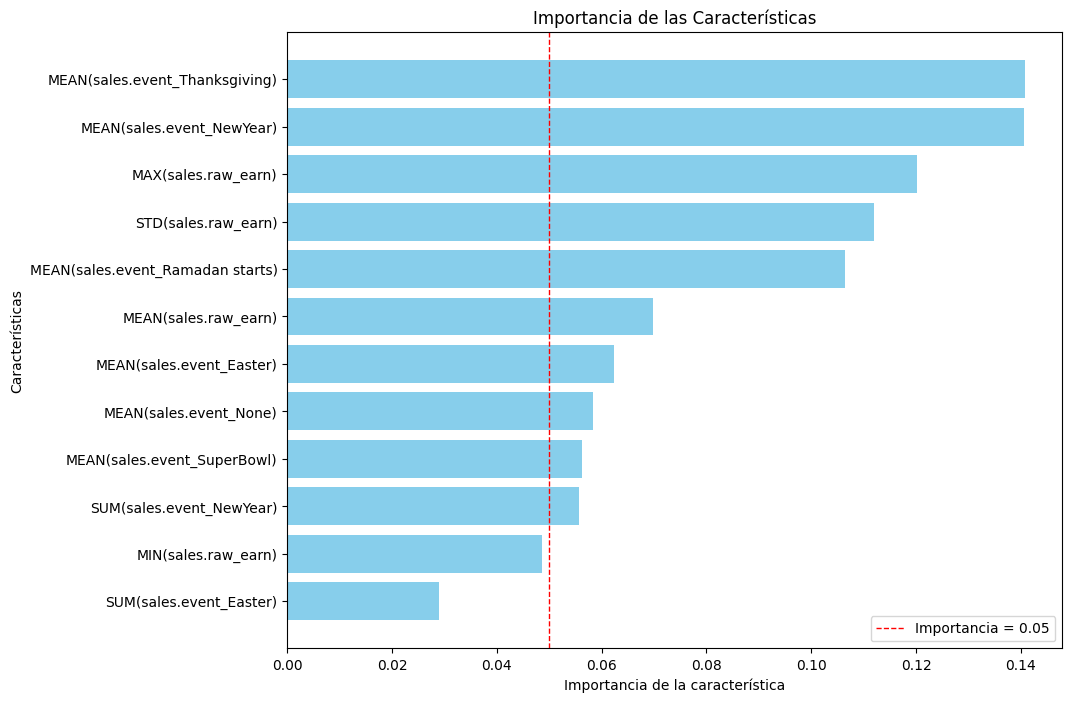

,Feature,Importance
0,MEAN(sales.event_Thanksgiving),0.140869
1,MEAN(sales.event_NewYear),0.140582
2,MAX(sales.raw_earn),0.120110
3,STD(sales.raw_earn),0.112063
4,MEAN(sales.event_Ramadan starts),0.106402
5,MEAN(sales.raw_earn),0.069770
6,MEAN(sales.event_Easter),0.062362
7,MEAN(sales.event_None),0.058266
8,MEAN(sales.event_SuperBowl),0.056337
9,SUM(sales.event_NewYear),0.055732


In [56]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
feats_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(feats_importance_df[feats_importance_df['Importance'] >= IMPORTANCE_THRES])

### Dimension Redux

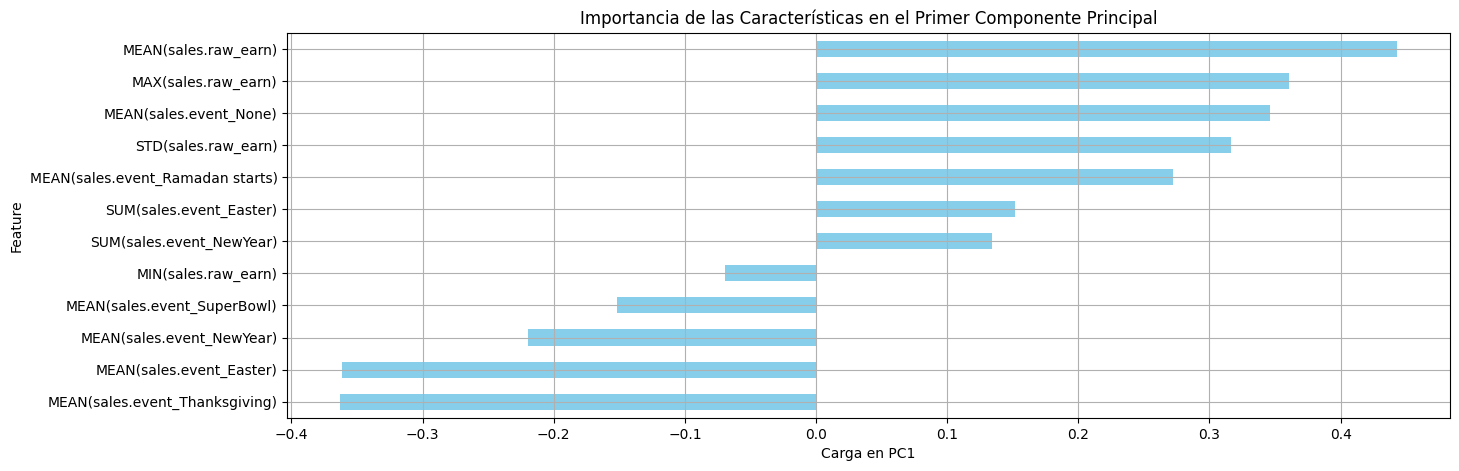

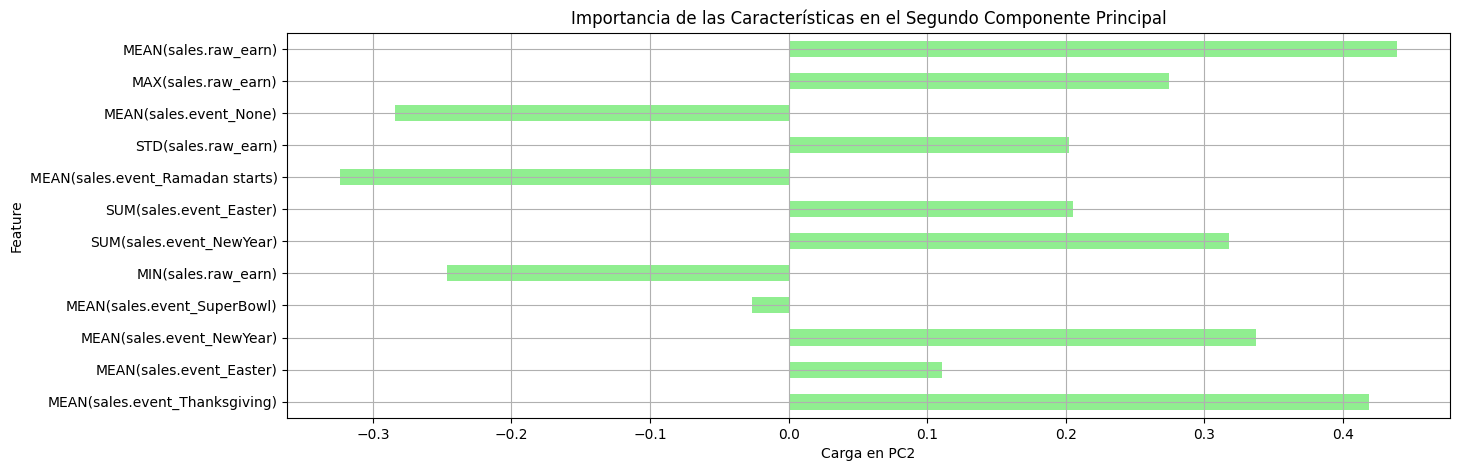

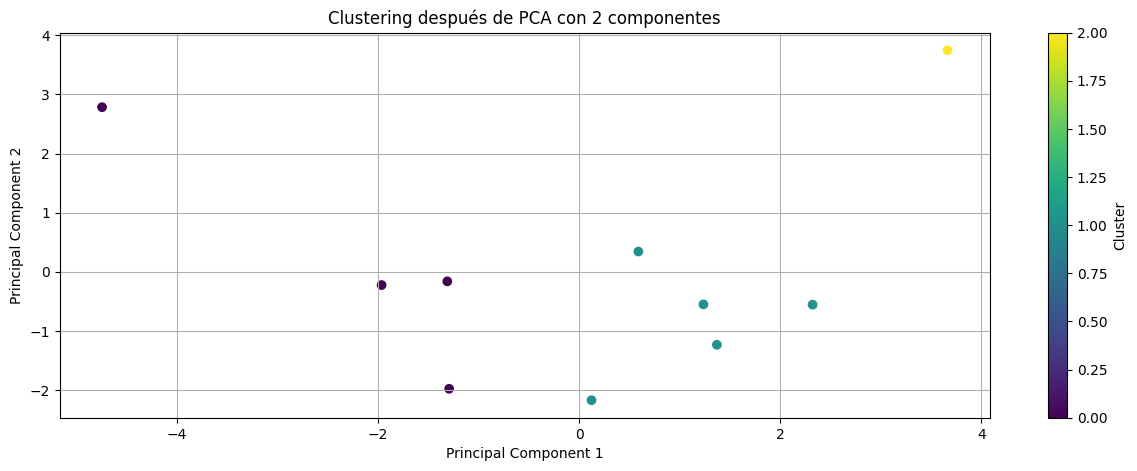

In [57]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

,MAX(sales.raw_earn),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MIN(sales.raw_earn),STD(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),PC1,PC2,Cluster
0,0.596752,-0.288318,0.018362,-0.419124,2.624210,-0.884789,-1.355612,0.908654,0.000000,0.265447,1.020505,1.241047,2.322751,-0.556005,1
1,-0.554384,0.013399,1.853154,-1.481161,-0.156028,0.062622,0.739378,0.044804,3.090909,-0.784661,-0.560409,0.042396,-1.963513,-0.223824,0
2,2.622752,-1.103102,0.742123,0.118106,-0.290920,-0.738232,0.580291,3.465769,-1.090909,1.627404,1.430597,2.015096,3.664357,3.747238,2
3,-0.494796,0.425127,-0.372069,-0.118106,0.800995,-0.558829,0.076640,-1.800360,-0.545455,-1.332077,-0.312219,-0.377710,-1.291954,-1.977611,0
4,-0.279639,-0.338988,-0.885381,0.886641,0.272713,0.441378,-0.505439,-0.780570,0.909091,-0.515529,-0.013416,-0.143247,0.123907,-2.171401,1


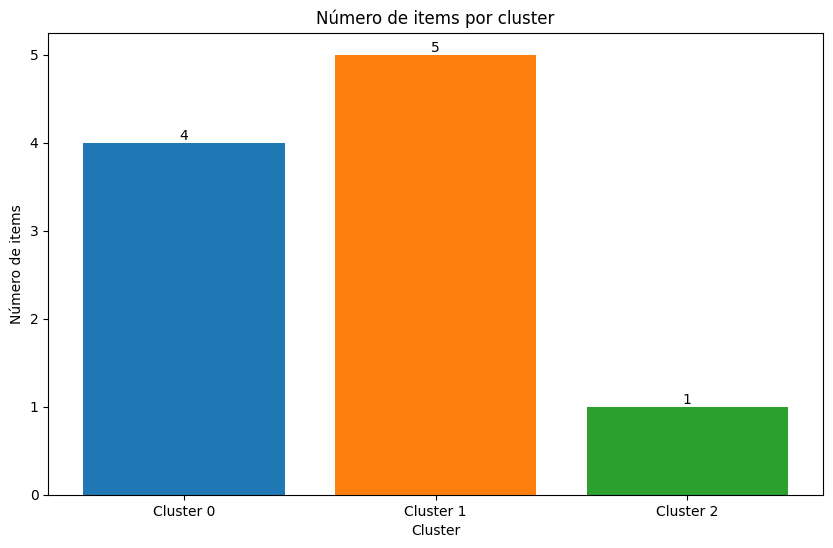

In [58]:
# Ejecutar PCA y clustering
n_components = 2

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar descripciones

In [59]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,1,0,2
MEAN(sales.raw_earn),0.122171,-0.796113,3.465769
MAX(sales.raw_earn),0.582004,-0.532542,2.622752
MEAN(sales.event_None),0.515101,-1.166692,0.118106
STD(sales.raw_earn),0.213156,-0.855723,1.627404
MEAN(sales.event_Ramadan starts),0.394197,-0.538886,-0.290920
SUM(sales.event_Easter),0.186234,-0.162817,1.430597
SUM(sales.event_NewYear),0.283925,0.119640,2.015096


In [60]:
description_df[sorted(description_df.columns)]

,0,1,2
MEAN(sales.raw_earn),-0.796113,0.122171,3.465769
MAX(sales.raw_earn),-0.532542,0.582004,2.622752
MEAN(sales.event_None),-1.166692,0.515101,0.118106
STD(sales.raw_earn),-0.855723,0.213156,1.627404
MEAN(sales.event_Ramadan starts),-0.538886,0.394197,-0.290920
SUM(sales.event_Easter),-0.162817,0.186234,1.430597
SUM(sales.event_NewYear),0.119640,0.283925,2.015096


In [61]:
# Asignacion clusters a shops
df_shops = df_shops.reset_index(drop=True) # Recuperamos indices originales

df_shops_with_clusters = df_shops.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_shops_with_clusters.head()

,store_code,region,store,Cluster
0,NYC_1,New York,Greenwich_Village,1
1,NYC_2,New York,Harlem,0
2,NYC_3,New York,Tribeca,2
3,NYC_4,New York,Brooklyn,0
4,BOS_1,Boston,South_End,1


In [62]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Underperforming Stores with Low Event Sensitivity',
        'description': 'Tiendas con ingresos bajos que no se benefician significativamente de los eventos. Estas tiendas presentan una baja varianza en las ventas y no muestran un impulso notable durante eventos importantes como el Año Nuevo o la Pascua. Son especialmente poco sensibles a eventos no festivos como el inicio del Ramadán.'
    },
    1: {
        'cluster_name': 'Moderately Event-Sensitive Stores',
        'description': 'Tiendas con ingresos moderados y una ligera influencia de eventos en las ventas. Estas tiendas tienen una respuesta decente durante el Año Nuevo y la Pascua, y muestran una estabilidad razonable en las ventas sin depender exclusivamente de eventos. Aunque no son muy sensibles, reaccionan a algunos eventos como el inicio del Ramadán.'
    },
    2: {
        'cluster_name': 'High Event-Driven Stores',
        'description': 'Tiendas con ingresos altos y una fuerte dependencia de eventos para incrementar sus ventas. Estas tiendas se destacan en eventos como el Año Nuevo y la Pascua, mostrando una alta varianza en las ventas y un impulso significativo durante estos momentos clave. Sin embargo, no parecen ser sensibles a eventos como el inicio del Ramadán.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
shops_with_cluster_info = df_shops_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(shops_with_cluster_info.head())

,store_code,region,store,Cluster,cluster_name,description
0,NYC_1,New York,Greenwich_Village,1,Moderately Event-Sensitive Stores,Tiendas con ingresos moderados y una ligera in...
1,NYC_2,New York,Harlem,0,Underperforming Stores with Low Event Sensitivity,Tiendas con ingresos bajos que no se beneficia...
2,NYC_3,New York,Tribeca,2,High Event-Driven Stores,Tiendas con ingresos altos y una fuerte depend...
3,NYC_4,New York,Brooklyn,0,Underperforming Stores with Low Event Sensitivity,Tiendas con ingresos bajos que no se beneficia...
4,BOS_1,Boston,South_End,1,Moderately Event-Sensitive Stores,Tiendas con ingresos moderados y una ligera in...


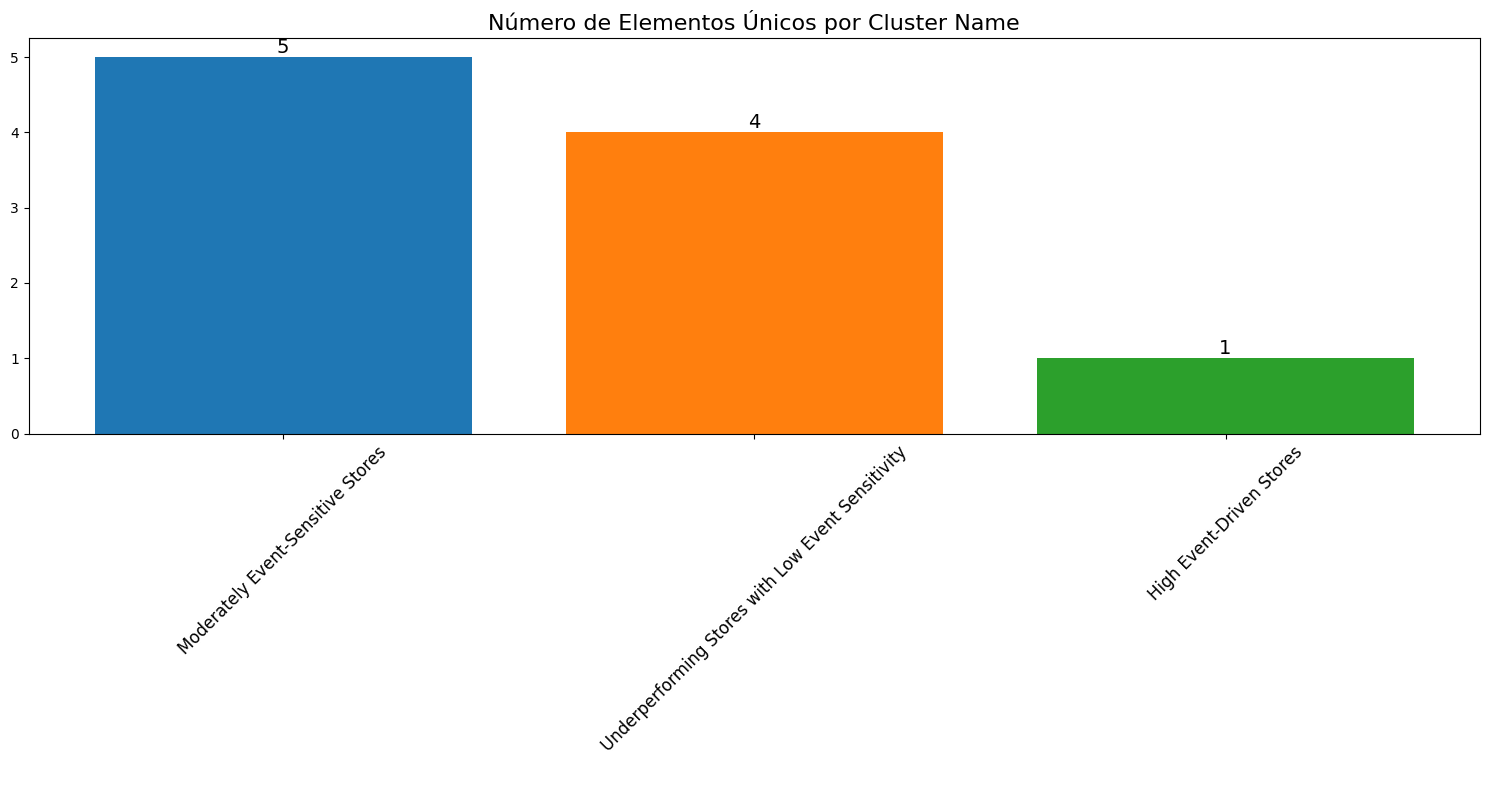

In [63]:
km_m.plot_clusters_with_name(shops_with_cluster_info)

## Guardamos csv

In [64]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_clusters_events_influence_sales.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# shops_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)